Using device: cpu
L shape: torch.Size([10000, 10000]), L device: cpu


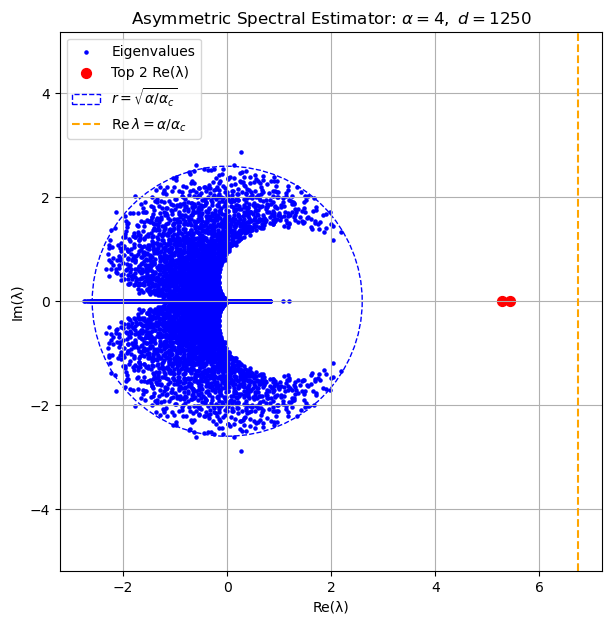

In [ ]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as besselk

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

# Experimental configuration
n = 5000        # number of samples
p = 2           # subspace dimension
alpha = 4
alpha_c = 0.59375
d = int(n / alpha)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Generate input matrix X ∈ ℝ^{n × d}
X = torch.randn(n, d, device=device) / np.sqrt(d)

# Construct signal subspace W* and observations Z = X W*
W_star = torch.randn(d, p, device=device)
Z = X @ W_star
z1, z2 = Z[:, 0], Z[:, 1]
y = z1 * z2  # nonlinear link function: y = z₁ · z₂

# Compute preprocessing function G(y) ∈ ℝ^{n × p × p}
y_cpu = y.detach().cpu().numpy()
abs_y = np.abs(y_cpu)
K1 = besselk(1, abs_y)
K0 = besselk(0, abs_y)
lambda_y = abs_y * (K1 / K0) - 1
lambda_y[np.isnan(lambda_y)] = 0  # ensure numerical stability

# Construct G(y): symmetric 2×2 matrix for each sample
G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y
G_y_np[:, 0, 1] = y_cpu
G_y_np[:, 1, 0] = y_cpu
G_y = torch.tensor(G_y_np, device=device)

# Build asymmetric spectral matrix L ∈ ℝ^{np × np}
XXT = X @ X.T  # shape: (n, n)
XXT.fill_diagonal_(0.0)  # remove diagonal entries

# Assemble block-wise spectral matrix L(iμ, jν)
A = XXT[:, :, None, None]            # shape: (n, n, 1, 1)
G_broadcast = G_y[None, :, :, :]     # shape: (1, n, p, p)
L_blocks = A * G_broadcast           # shape: (n, n, p, p)
L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)  # shape: (np, np)
print(f"L shape: {L.shape}, L device: {L.device}")

# Eigenvalue computation and visualization
eigvals = torch.linalg.eigvals(L)
eigvals_np = eigvals.detach().cpu().numpy()
eigvals_real = eigvals_np.real

# Select top-2 eigenvalues by real part
top2_idx = np.argsort(eigvals_real)[-2:]
top2_vals = eigvals_np[top2_idx]

# Eigenvalue spectrum visualization
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, s=5, color='blue', label='Eigenvalues')
plt.scatter(top2_vals.real, top2_vals.imag, color='red', s=50, label='Top 2 Re(λ)')

# Theoretical spectral radius and outlier threshold
r = np.sqrt(alpha / alpha_c)
thresh = alpha / alpha_c

circle = plt.Circle((0, 0), r, color='blue', fill=False, linestyle='--',
                    label=rf'$r = \sqrt{{\alpha / \alpha_c}}$')
plt.gca().add_artist(circle)
plt.axvline(x=thresh, color='orange', linestyle='--',
            label=rf'$\mathrm{{Re}}\,\lambda = \alpha / \alpha_c$')

# Figure formatting
plt.xlabel('Re(λ)')
plt.ylabel('Im(λ)')
plt.title(rf'Asymmetric Spectral Estimator: $\alpha = {alpha},\ d = {d}$')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


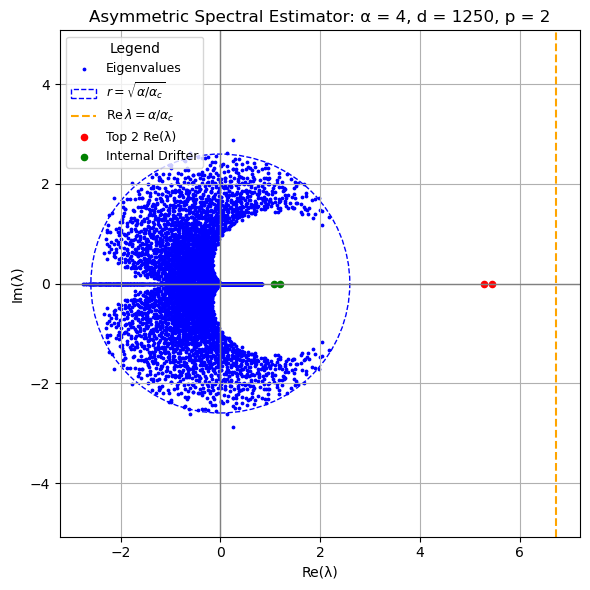

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import norm

# Threshold definitions
R = np.sqrt(alpha / alpha_c)        # radius of theoretical spectral circle
thresh_ext = alpha / alpha_c        # theoretical outlier threshold on the real axis

# Select real-valued eigenvalues
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]
real_parts = eigvals_real_only.real

# Red points: top-2 eigenvalues by Re(λ)
red_vals = eigvals_real_only[np.argsort(real_parts)[-2:]]

# Green points: top-3 eigenvalues inside the circle (Re(λ) < R)
green_candidates = [val for val in eigvals_real_only if val.real < R]
green_vals = sorted(green_candidates, key=lambda z: -z.real)[:2]

# Visualization
plt.figure(figsize=(6, 6))

# Plot all eigenvalues (blue)
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")

# Theoretical spectral radius (blue dashed circle)
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False,
                    label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)

# Theoretical outlier threshold (orange dashed line)
plt.axvline(thresh_ext, color="orange", linestyle="--",
            label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")

# Highlight red points (R1, R2)
for i, val in enumerate(sorted(red_vals, key=lambda x: -x.real)):
    plt.scatter(val.real, val.imag, color="red", s=20,
                label="Top 2 Re(λ)" if i == 0 else None)

# Highlight green points (G1–G3)
for i, val in enumerate(sorted(green_vals, key=lambda x: -x.real)):
    plt.scatter(val.real, val.imag, color="green", s=20,
                label="Internal Drifter" if i == 0 else None)

# Axes, labels, and legend formatting
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = {p}")
plt.legend(loc='upper left', fontsize=9, title="Legend", title_fontsize=10)
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.linalg import qr

# Define generalized overlap evaluation function
def generalized_overlap_corrected(W_star, eigvals_np, eigvecs_np, target_vals, label_prefix, X):
    results = []
    d = W_star.shape[0]
    W_orth, _ = qr(W_star, mode='economic')  # Orthonormalize W_star
    X_cpu = X.cpu().numpy().T  # shape: (d, n)

    for i, val in enumerate(target_vals):
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx]
        V = v_hat.reshape(-1, 2)  # shape: (n, 2)
        U = X_cpu @ V             # shape: (d, 2)

        for j in range(2):
            u = U[:, j]
            u_hat = u / norm(u)
            q = norm(W_orth.T @ u_hat) ** 2  # squared projection overlap
            results.append((f"{label_prefix}{i+1}-{j+1}", val, q))
    return results

# Eigen-decomposition and variable preparation
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
W_star_np = W_star.cpu().numpy()

# Compute single-point overlaps for selected eigenvalues
results_red = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, red_vals, "Red", X)
results_green = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, green_vals, "Green", X)

# Combine results and construct DataFrame
all_results = results_red + results_green
df_result = pd.DataFrame(sorted(all_results, key=lambda x: -x[2]),
                         columns=["Label", "Eigenvalue", "Overlap_q"])

print(df_result)


      Label          Eigenvalue  Overlap_q
0  Green2-2  1.070235+0.000000j   0.512579
1  Green2-1  1.070235+0.000000j   0.512579
2  Green1-2  1.189739+0.000000j   0.502130
3  Green1-1  1.189739+0.000000j   0.502129
4    Red2-2  5.441175+0.000000j   0.351025
5    Red2-1  5.441175+0.000000j   0.351025
6    Red1-1  5.286231+0.000000j   0.310806
7    Red1-2  5.286231+0.000000j   0.310806


In [ ]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
from itertools import combinations
from scipy.linalg import qr

# Define function to compute rank-2 overlap (without Pt indices)
def rank2_overlap_from_labels(W_star, eigvals_np, eigvecs_np, df_result, X):
    results = []
    d = W_star.shape[0]
    W_orth, _ = qr(W_star, mode='economic')  # Orthonormalize W_star
    X_cpu = X.cpu().numpy().T  # shape: (d, n)

    v_map = {}  # Mapping from label → corresponding eigenvector direction

    # Map each labeled eigenvector to its respective direction
    for i, row in enumerate(df_result.itertuples()):
        label = row.Label
        val = row.Eigenvalue
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx]
        V = v_hat.reshape(-1, 2)  # shape: (n, 2)
        j = 0 if '1' in label[-3:] else 1  # Determine direction index based on label suffix
        v_map[label] = V[:, j]

    # Enumerate all unique combinations of eigenvector pairs
    for (id1, v1), (id2, v2) in combinations(v_map.items(), 2):
        U = X_cpu @ np.column_stack([v1, v2])  # shape: (d, 2)
        U, _ = qr(U, mode='economic')  # Orthonormalize U
        q = np.linalg.norm(W_orth.T @ U, ord='fro')**2  # Frobenius norm squared
        results.append((f"{id1} + {id2}", q))

    return pd.DataFrame(results, columns=["ComboLabel", "Rank2_Overlap_q"])\
             .sort_values("Rank2_Overlap_q", ascending=False)\
             .reset_index(drop=True)

df_rank2 = rank2_overlap_from_labels(W_star_np, eigvals_np, eigvecs_np, df_result, X)

# Display results
pd.set_option("display.max_rows", None)
print(df_rank2)


             ComboLabel  Rank2_Overlap_q
0   Green2-2 + Green1-1         1.014794
1   Green2-2 + Green1-2         1.014794
2   Green2-1 + Green1-2         1.014793
3   Green2-1 + Green1-1         1.014793
4     Green1-2 + Red2-2         0.853293
5     Green1-1 + Red2-2         0.853293
6     Green1-1 + Red2-1         0.853292
7     Green1-2 + Red2-1         0.853292
8     Green2-2 + Red1-1         0.823501
9     Green2-2 + Red1-2         0.823501
10    Green2-1 + Red1-1         0.823501
11    Green2-1 + Red1-2         0.823501
12      Red2-1 + Red1-1         0.661998
13      Red2-1 + Red1-2         0.661998
14      Red2-2 + Red1-1         0.661998
15      Red2-2 + Red1-2         0.661998
16      Red2-2 + Red2-1         0.661040
17    Green2-2 + Red2-2         0.547702
18    Green2-1 + Red2-2         0.547701
19    Green2-2 + Red2-1         0.547701
20    Green2-1 + Red2-1         0.547701
21    Green1-2 + Red1-1         0.532693
22    Green1-2 + Red1-2         0.532693
23    Green1-1 +

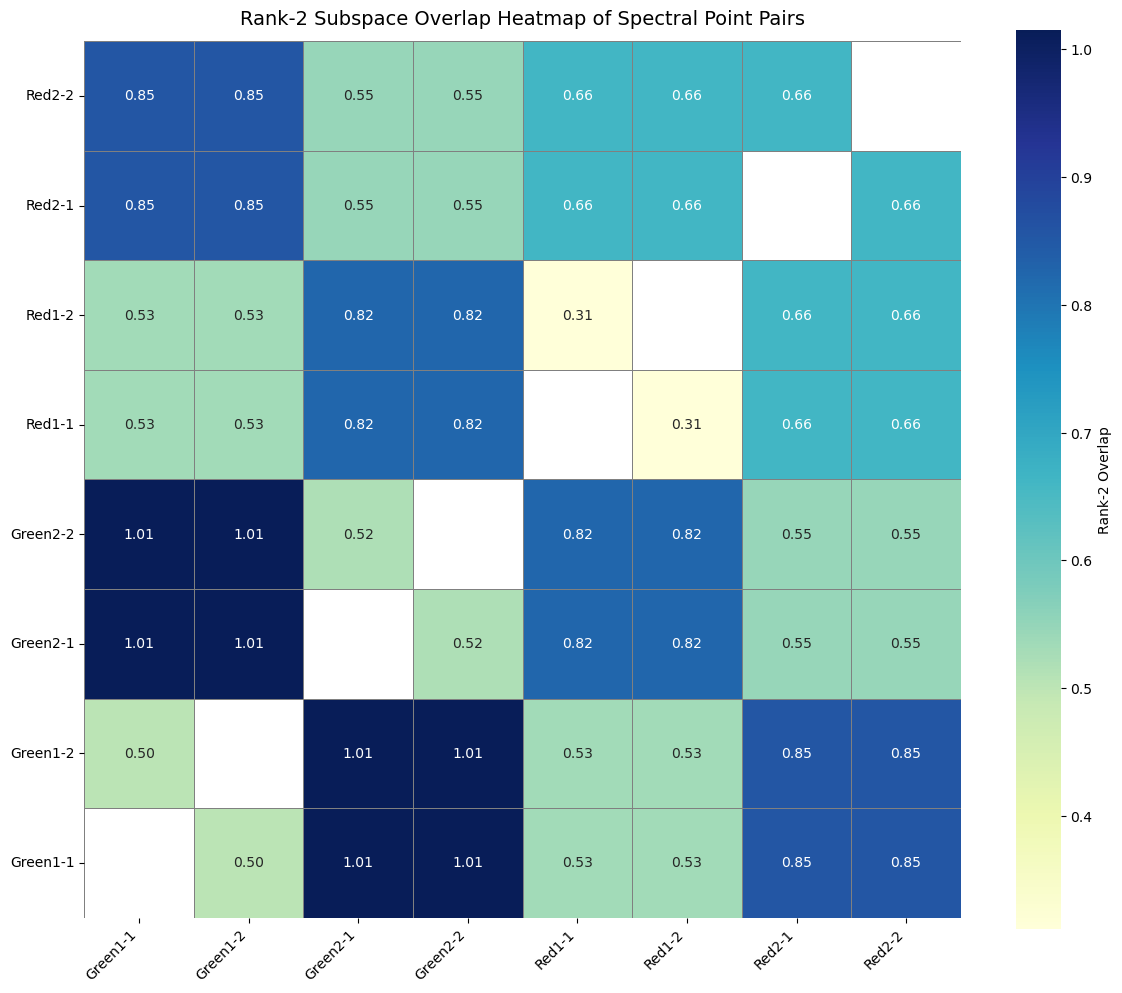

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import re

# Define custom sorting function for labels
def custom_sort_key(label):
    try:
        color = "green" if label.lower().startswith("green") else "red"
        nums = re.findall(r'\d+', label)  # extract numeric indices
        if len(nums) < 2:
            raise ValueError(f"Label format error: {label}")
        return (0 if color == "green" else 1, int(nums[0]), int(nums[1]))
    except Exception as e:
        print(f"[Label Sorting Error] {label}: {e}")
        return (999, 999, 999)

# Extract and sort all unique labels
all_labels = sorted(
    set(sum([label.split(' + ') for label in df_rank2['ComboLabel'] if isinstance(label, str)], [])),
    key=custom_sort_key
)

# Initialize an empty symmetric matrix for rank-2 overlaps
heatmap_matrix = pd.DataFrame(np.nan, index=all_labels, columns=all_labels)

# Populate the matrix with Rank-2 Overlap values
for _, row in df_rank2.iterrows():
    if isinstance(row['ComboLabel'], str) and ' + ' in row['ComboLabel']:
        a, b = row['ComboLabel'].split(' + ')
        heatmap_matrix.loc[a, b] = row['Rank2_Overlap_q']
        heatmap_matrix.loc[b, a] = row['Rank2_Overlap_q']

# Mask the diagonal (self-pairs are not displayed)
np.fill_diagonal(heatmap_matrix.values, np.nan)

# Identify the top-5 combinations by rank-2 overlap
top5 = df_rank2.nlargest(5, 'Rank2_Overlap_q')

# Plot the heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    heatmap_matrix, annot=True, fmt=".2f", cmap="YlGnBu", square=True,
    cbar_kws={'label': 'Rank-2 Overlap'}, linewidths=0.5, linecolor='gray'
)

# Title and axis formatting
plt.title("Rank-2 Subspace Overlap Heatmap of Spectral Point Pairs", fontsize=14, pad=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
ax.invert_yaxis()  # invert y-axis for standard orientation

# Optimize layout
plt.tight_layout()
plt.show()


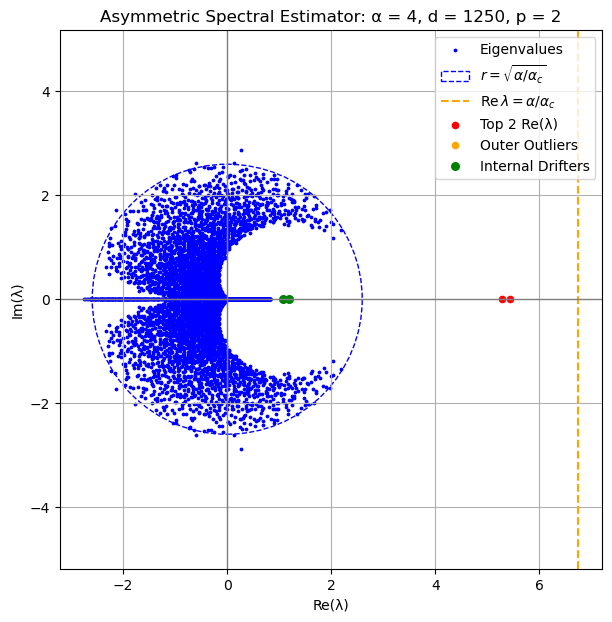

      Type      λ (eigval)  Alignment Score
0    Red-1  5.2862+0.0000j           0.5741
1    Red-2  5.4412+0.0000j           0.5746
2  Green-1  1.1897+0.0000j           0.4621
3  Green-2  1.0702+0.0000j           0.3983


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.linalg import qr
import pandas as pd

# Alignment evaluation function
def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# Extract subspace from eigenvectors and compute alignment
def extract_W_from_eigenvectors(eigvecs_np, eigval_target, X, W_star, p=2, label=""):
    """
    Select the eigenvector associated with a target eigenvalue,
    map it back to the d-dimensional subspace, and compute the alignment score.
    """
    idx = np.argmin(np.abs(eigvals_np - eigval_target))
    v_hat = eigvecs_np[:, idx]          # shape: (n*p,)
    V = v_hat.reshape(-1, p)            # shape: (n, p)
    U = (X.cpu().numpy().T) @ V         # shape: (d, p)
    W_hat = U / np.linalg.norm(U, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_target, score)

# Eigen-decomposition and eigenpair extraction
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
W_star_np = W_star.cpu().numpy()
d = W_star_np.shape[0]

# Threshold definitions
R = np.sqrt(alpha / alpha_c)        # theoretical spectral radius
thresh_ext = alpha / alpha_c        # theoretical outlier threshold

# Select real-valued eigenvalues
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]
real_parts = eigvals_real_only.real

# Red points: top-2 eigenvalues by Re(λ)
red_vals = eigvals_real_only[np.argsort(real_parts)[-2:]]

# Orange points: eigenvalues beyond theoretical threshold (outer outliers)
orange_vals = [val for val in eigvals_real_only if val.real > thresh_ext]

# Green points: top-2 eigenvalues inside the circle (Re(λ) < R)
green_candidates = [val for val in eigvals_real_only if val.real < R]
green_vals = sorted(green_candidates, key=lambda z: -z.real)[:2]

# Visualization of eigenvalue spectrum
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")

# Theoretical spectral radius (blue dashed circle)
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False,
                    label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)

# Theoretical threshold for outliers
plt.axvline(thresh_ext, color="orange", linestyle="--",
            label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")

# Highlight red points (top-2 Re(λ))
plt.scatter([z.real for z in red_vals], [z.imag for z in red_vals],
            color="red", s=20, label="Top 2 Re(λ)")

# Highlight orange points (outer outliers)
plt.scatter([z.real for z in orange_vals], [z.imag for z in orange_vals],
            color="orange", s=20, label="Outer Outliers")

# Highlight green points (internal drifters)
if len(green_vals) > 0:
    plt.scatter([z.real for z in green_vals], [z.imag for z in green_vals],
                color="green", s=30, label="Internal Drifters")

# Axes formatting
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# Compute alignment scores for selected eigenvalues
results = []

# Red points
for i, val in enumerate(red_vals):
    label = f"Red-{i+1}"
    results.append(extract_W_from_eigenvectors(eigvecs_np, val, X, W_star, p=2, label=label))

# Orange points
for i, val in enumerate(orange_vals):
    label = f"Orange-{i+1}"
    results.append(extract_W_from_eigenvectors(eigvecs_np, val, X, W_star, p=2, label=label))

# Green points
for i, val in enumerate(green_vals):
    label = f"Green-{i+1}"
    results.append(extract_W_from_eigenvectors(eigvecs_np, val, X, W_star, p=2, label=label))

# Display results in a DataFrame
df = pd.DataFrame(results, columns=["Type", "λ (eigval)", "Alignment Score"])
pd.set_option("display.precision", 4)
print(df)


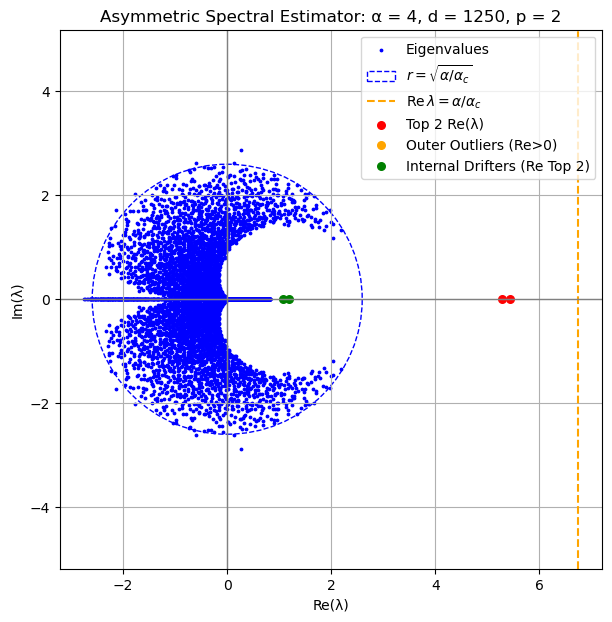

                     Type              λ1              λ2  Alignment Score
0      Red-Red(5.44,5.29)  5.4412+0.0000j  5.2862+0.0000j           0.5746
1    Red-Green(5.44,1.19)  5.4412+0.0000j  1.1897+0.0000j           0.5746
2    Red-Green(5.44,1.07)  5.4412+0.0000j  1.0702+0.0000j           0.5746
3    Red-Green(5.29,1.19)  5.2862+0.0000j  1.1897+0.0000j           0.5741
4    Red-Green(5.29,1.07)  5.2862+0.0000j  1.0702+0.0000j           0.5741
5  Green-Green(1.19,1.07)  1.1897+0.0000j  1.0702+0.0000j           0.4621


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.linalg import qr
import pandas as pd
from itertools import combinations

# Compute subspace alignment score
def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# Extract estimated subspace from eigenvector pairs and compute alignment
def extract_W_from_eigpair(eigvecs_np, eigvals_np, eigval_pair, X, W_star, p=2, label=""):
    idx1 = np.argmin(np.abs(eigvals_np - eigval_pair[0]))
    idx2 = np.argmin(np.abs(eigvals_np - eigval_pair[1]))
    v1 = eigvecs_np[:, idx1]
    v2 = eigvecs_np[:, idx2]

    V1 = v1.reshape(-1, p)
    V2 = v2.reshape(-1, p)
    V = np.hstack([V1, V2])
    
    U = X.cpu().numpy().T @ V
    W_hat = U[:, :p]
    W_hat = W_hat / norm(W_hat, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_pair[0], eigval_pair[1], score)

# Eigen-decomposition: extract eigenvalues and eigenvectors
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
W_star_np = W_star.cpu().numpy()
d = W_star_np.shape[0]

# Classify eigenvalues into categories: red, orange, green
R = np.sqrt(alpha / alpha_c)        # theoretical spectral radius
thresh_ext = alpha / alpha_c        # theoretical outlier threshold

real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]

# Red points: top-2 eigenvalues by Re(λ)
red_vals = sorted(eigvals_real_only, key=lambda z: z.real, reverse=True)[:2]

# Orange points: outliers with positive Re(λ) beyond spectral radius
orange_candidates = [z for z in eigvals_real_only if abs(z) > R and z.real > 0]
orange_vals = [z for z in orange_candidates if z not in red_vals]

# Green points: top-2 internal eigenvalues (inside circle, highest Re)
green_candidates = [z for z in eigvals_np if np.isclose(z.imag, 0.0, atol=1e-6) and abs(z) <= R]
green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:2]

# Visualization of eigenvalue spectrum (optional)
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False,
                    label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--",
            label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")

plt.scatter([z.real for z in red_vals], [z.imag for z in red_vals],
            color="red", s=30, label="Top 2 Re(λ)")
plt.scatter([z.real for z in orange_vals], [z.imag for z in orange_vals],
            color="orange", s=30, label="Outer Outliers (Re>0)")
plt.scatter([z.real for z in green_vals], [z.imag for z in green_vals],
            color="green", s=30, label="Internal Drifters (Re Top 2)")

plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# Generate all pairwise combinations of highlighted eigenvalues (red, orange, green)
highlight_vals = [("Red", z) for z in red_vals] + \
                 [("Orange", z) for z in orange_vals] + \
                 [("Green", z) for z in green_vals]

results = []
for (label1, z1), (label2, z2) in combinations(highlight_vals, 2):
    pair_label = f"{label1}-{label2}({z1.real:.2f},{z2.real:.2f})"
    result = extract_W_from_eigpair(eigvecs_np, eigvals_np, (z1, z2), X, W_star, p=2, label=pair_label)
    results.append(result)

# Display results in a DataFrame
df = pd.DataFrame(results, columns=["Type", "λ1", "λ2", "Alignment Score"])
pd.set_option("display.precision", 4)
print(df.sort_values(by="Alignment Score", ascending=False))


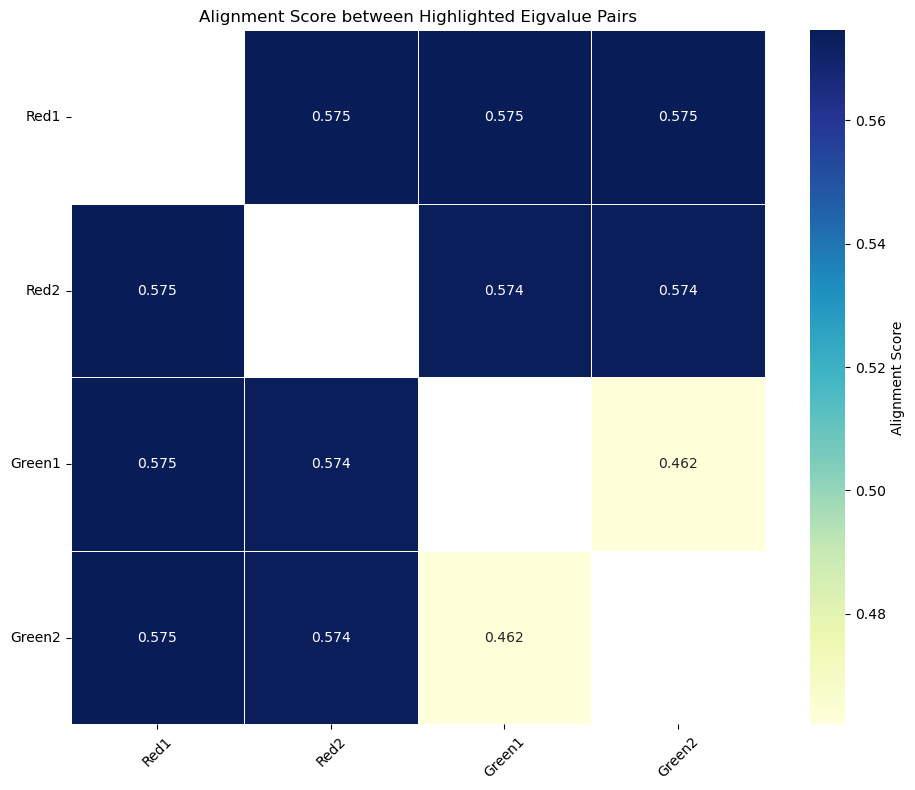

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assign labels to selected eigenvalues: Red1, Red2, Orange1..., Green2
point_labels = [("Red", i+1, z) for i, z in enumerate(red_vals)] + \
               [("Orange", i+1, z) for i, z in enumerate(orange_vals)] + \
               [("Green", i+1, z) for i, z in enumerate(green_vals)]

# Map labels to eigenvalues: {"Red1": λ, "Orange2": λ, ...}
label_map = {f"{color}{i}": z for color, i, z in point_labels}
label_list = list(label_map.keys())

# Initialize an empty symmetric DataFrame for alignment scores
heatmap_df = pd.DataFrame(np.nan, index=label_list, columns=label_list)

# Fill the matrix with alignment scores for eigenvalue pairs
for (label1, z1), (label2, z2) in combinations(label_map.items(), 2):
    _, _, _, score = extract_W_from_eigpair(eigvecs_np, eigvals_np, (z1, z2), X, W_star, p=2)
    heatmap_df.loc[label1, label2] = score
    heatmap_df.loc[label2, label1] = score  # enforce symmetry

# Visualize the alignment heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_df,
    annot=True,
    cmap="YlGnBu",
    fmt=".3f",
    square=True,
    linewidths=0.5,
    cbar_kws={"label": "Alignment Score"}
)
plt.title("Alignment Score between Highlighted Eigenvalue Pairs")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


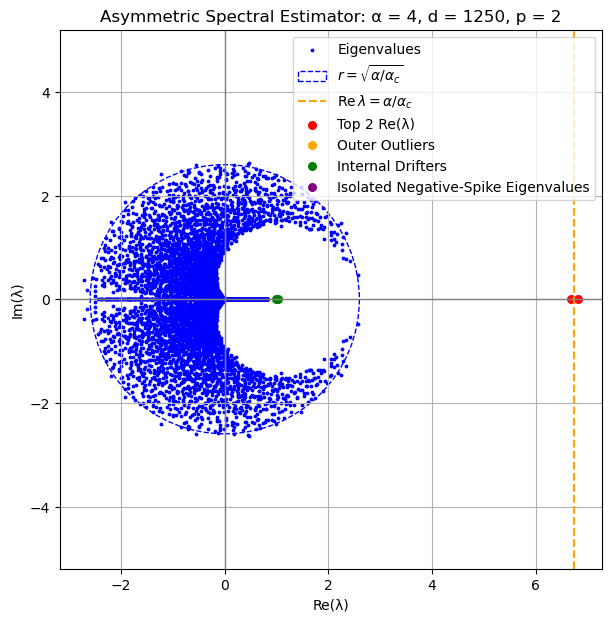


=== Alignment Score for Individual Eigenvalues ===
     Type                   λ  Alignment Score
0  Green1  1.022425+0.000000j         0.661997
1  Green2  0.984344+0.000000j         0.640446
2    Red1  6.804509+0.000000j         0.591476
3    Red2  6.684873+0.000000j         0.593044

=== Alignment Score for Pairs of Eigenvalues ===
            Pair                  λ1                  λ2  Alignment Score
0  Green1-Green2  1.022425+0.000000j  0.984344+0.000000j         0.661997
1    Green1-Red1  1.022425+0.000000j  6.804509+0.000000j         0.661997
2    Green1-Red2  1.022425+0.000000j  6.684873+0.000000j         0.661997
3    Green2-Red1  0.984344+0.000000j  6.804509+0.000000j         0.640446
4    Green2-Red2  0.984344+0.000000j  6.684873+0.000000j         0.640446
5      Red1-Red2  6.804509+0.000000j  6.684873+0.000000j         0.591476


/var/folders/kl/6hy0lk_14w14xqln8byr8l940000gn/T/ipykernel_4438/3961009064.py:235: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


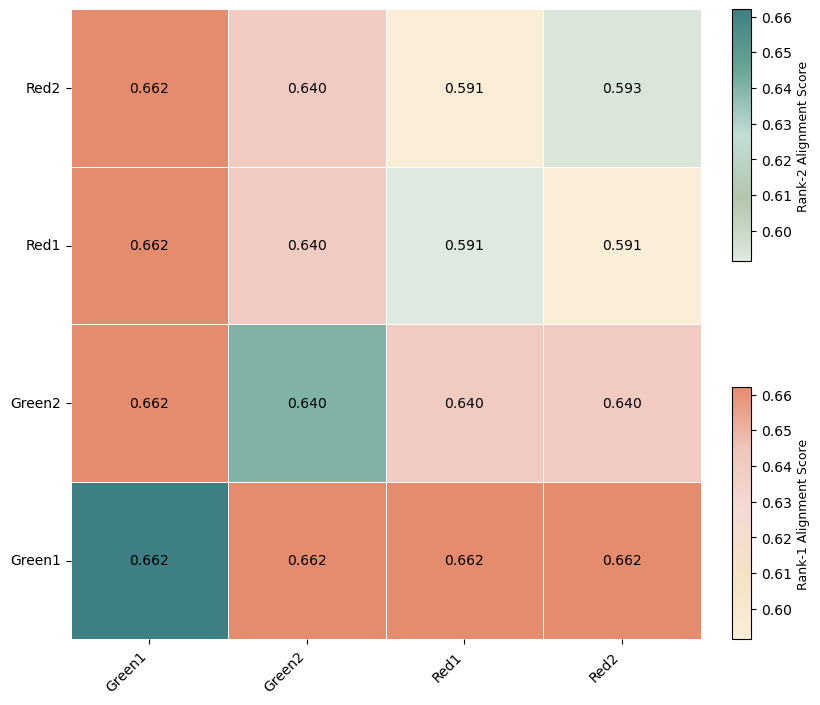

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy.linalg import norm
from scipy.linalg import qr
from itertools import combinations

# Threshold definitions
alpha = 4
alpha_c = 0.59375
R = np.sqrt(alpha / alpha_c)        # theoretical spectral radius
thresh_ext = alpha / alpha_c        # theoretical outlier threshold

# Alignment score function
def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# Subspace extraction (single eigenvalue)
def extract_W_from_eigenvectors(eigvecs_np, eigval_target, X, W_star, p=2, label=""):
    idx = np.argmin(np.abs(eigvals_np - eigval_target))
    v_hat = eigvecs_np[:, idx]
    V = v_hat.reshape(-1, p)
    U = (X.cpu().numpy().T) @ V
    W_hat = U / np.linalg.norm(U, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_target, score)

# Subspace extraction (eigenvalue pairs)
def extract_W_from_eigpair(eigvecs_np, eigvals_np, eigval_pair, X, W_star, p=2, label=""):
    idx1 = np.argmin(np.abs(eigvals_np - eigval_pair[0]))
    idx2 = np.argmin(np.abs(eigvals_np - eigval_pair[1]))
    v1 = eigvecs_np[:, idx1]
    v2 = eigvecs_np[:, idx2]
    V1 = v1.reshape(-1, p)
    V2 = v2.reshape(-1, p)
    V = np.hstack([V1, V2])
    U = X.cpu().numpy().T @ V
    W_hat = U[:, :p]
    W_hat = W_hat / norm(W_hat, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_pair[0], eigval_pair[1], score)

# Eigen-decomposition
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()

# Eigenvalue classification: red, orange, green, purple
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real = eigvals_np[real_mask]

outside_vals = [z for z in eigvals_real if abs(z) > R]
inside_vals = [z for z in eigvals_real if abs(z) <= R and z.real > 0]

red_vals = sorted(eigvals_real, key=lambda z: z.real, reverse=True)[:2]
orange_vals = [z for z in outside_vals if z.real > 0 and z not in red_vals]
green_candidates = [z for z in inside_vals if z.real > 0]
green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:2]
purple_vals = [z for z in outside_vals if z.real < -R]

# Eigenvalue labeling (sorted within each category)
green_labels = [(f"Green{i+1}", z) for i, z in enumerate(sorted(green_vals, key=lambda z: z.real, reverse=True))]
orange_labels = [(f"Orange{i+1}", z) for i, z in enumerate(sorted(orange_vals, key=lambda z: z.real, reverse=True))]
red_labels = [(f"Red{i+1}", z) for i, z in enumerate(sorted(red_vals, key=lambda z: z.real, reverse=True))]
purple_labels = [(f"Purple{i+1}", z) for i, z in enumerate(sorted(purple_vals, key=lambda z: z.real, reverse=True))]

# Combine labels
all_labels = green_labels + orange_labels + red_labels
label_order = [label for label, _ in all_labels]

# Eigenvalue spectrum visualization
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")
plt.scatter([z.real for _, z in red_labels], [z.imag for _, z in red_labels], color="red", s=30, label="Top 2 Re(λ)")
plt.scatter([z.real for _, z in orange_labels], [z.imag for _, z in orange_labels], color="orange", s=30, label="Outer Outliers")
plt.scatter([z.real for _, z in green_labels], [z.imag for _, z in green_labels], color="green", s=30, label="Internal Drifters")
plt.scatter([z.real for _, z in purple_labels], [z.imag for _, z in purple_labels], color="purple", s=30, label="Negative Outliers")
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# Build final label order including purple points
def build_desired_order(purple_labels, green_labels, orange_labels, red_labels):
    label_groups = [
        ("Purple", purple_labels),
        ("Green", green_labels),
        ("Orange", orange_labels),
        ("Red", red_labels),
    ]
    desired_order = []
    for _, labels in label_groups:
        for label, _ in labels:
            desired_order.append(label)
    return desired_order

label_dict = dict(green_labels + orange_labels + red_labels + purple_labels)
desired_order = build_desired_order(purple_labels, green_labels, orange_labels, red_labels)
all_labels = [(label, label_dict[label]) for label in desired_order if label in label_dict]
label_order = [label for label, _ in all_labels]

# Alignment scores for individual eigenvalues
results_single = []
for label, z in all_labels:
    res = extract_W_from_eigenvectors(eigvecs_np, z, X, W_star, p=2, label=label)
    results_single.append(res)
df_single = pd.DataFrame(results_single, columns=["Type", "λ", "Alignment Score"])
print("\n=== Alignment Score for Individual Eigenvalues ===")
print(df_single)

# Alignment scores for eigenvalue pairs
results_pair = []
for (label1, z1), (label2, z2) in combinations(all_labels, 2):
    pair_label = f"{label1}-{label2}"
    results_pair.append(extract_W_from_eigpair(eigvecs_np, eigvals_np, (z1, z2), X, W_star, p=2, label=pair_label))
df_pair = pd.DataFrame(results_pair, columns=["Pair", "λ1", "λ2", "Alignment Score"])
print("\n=== Alignment Score for Pairs of Eigenvalues ===")
print(df_pair.sort_values(by="Alignment Score", ascending=False))

# Heatmap visualization including purple points
heatmap_df = pd.DataFrame(np.nan, index=label_order, columns=label_order)

# Fill diagonal with single-point alignment scores
for _, row in df_single.iterrows():
    heatmap_df.loc[row["Type"], row["Type"]] = row["Alignment Score"]

# Fill off-diagonal with pairwise alignment scores
for _, row in df_pair.iterrows():
    l1, l2 = row["Pair"].split("-")
    heatmap_df.loc[l1, l2] = row["Alignment Score"]
    heatmap_df.loc[l2, l1] = row["Alignment Score"]

# Prepare masks for diagonal and off-diagonal
mask_diag = pd.DataFrame(True, index=label_order, columns=label_order)
np.fill_diagonal(mask_diag.values, False)
mask_offdiag = ~mask_diag

# Value range
vmin = np.nanmin(heatmap_df.values)
vmax = np.nanmax(heatmap_df.values)

# Define colormaps
diag_colors = ["#FAEED9", "#F5E3C2", "#F5DBD4", "#F0C7BC", "#E58B6E"]
offdiag_colors = ["#DFE9DF", "#B2C6AB", "#C2DED7", "#6DA798", "#3E7F84"]
diag_cmap = LinearSegmentedColormap.from_list("diag_cmap", diag_colors)
offdiag_cmap = LinearSegmentedColormap.from_list("offdiag_cmap", offdiag_colors)

# Plot heatmap
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(heatmap_df, mask=mask_diag, cmap=offdiag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)
sns.heatmap(heatmap_df, mask=mask_offdiag, cmap=diag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)

# Annotate alignment scores on cells
for i in range(len(label_order)):
    for j in range(len(label_order)):
        val = heatmap_df.iloc[i, j]
        if not np.isnan(val):
            ax.text(j + 0.5, i + 0.5, f"{val:.3f}", ha='center', va='center', fontsize=10)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.invert_yaxis()
plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.90, top=0.95, bottom=0.05)
plt.show()


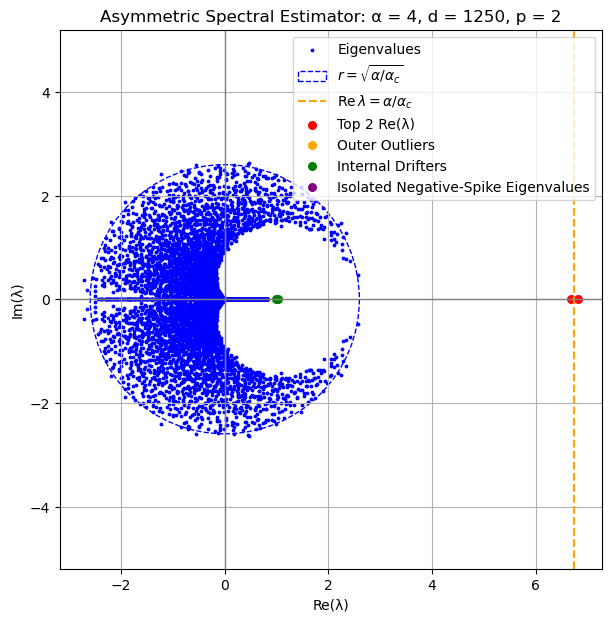


=== Alignment Score for Individual Eigenvalues ===
     Type                   λ  Alignment Score
0  Green1  1.022425+0.000000j         0.661997
1  Green2  0.984344+0.000000j         0.640446
2    Red1  6.804509+0.000000j         0.591476
3    Red2  6.684873+0.000000j         0.593044

=== Alignment Score for Pairs of Eigenvalues ===
            Pair                  λ1                  λ2  Alignment Score
0  Green1-Green2  1.022425+0.000000j  0.984344+0.000000j         0.661997
1    Green1-Red1  1.022425+0.000000j  6.804509+0.000000j         0.661997
2    Green1-Red2  1.022425+0.000000j  6.684873+0.000000j         0.661997
3    Green2-Red1  0.984344+0.000000j  6.804509+0.000000j         0.640446
4    Green2-Red2  0.984344+0.000000j  6.684873+0.000000j         0.640446
5      Red1-Red2  6.804509+0.000000j  6.684873+0.000000j         0.591476


/var/folders/kl/6hy0lk_14w14xqln8byr8l940000gn/T/ipykernel_4438/4148119382.py:232: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


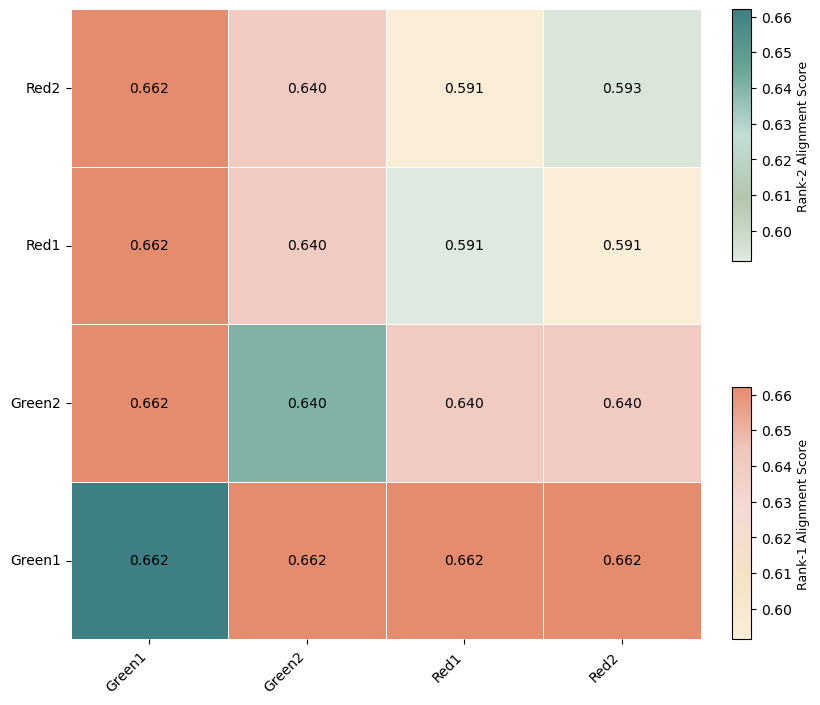

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy.linalg import norm
from scipy.linalg import qr
from itertools import combinations

# Threshold definitions
R = np.sqrt(alpha / alpha_c)        # theoretical spectral radius
thresh_ext = alpha / alpha_c        # theoretical outlier threshold

# Alignment score
def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# Subspace extraction (single eigenvalue)
def extract_W_from_eigenvectors(eigvecs_np, eigval_target, X, W_star, p=2, label=""):
    idx = np.argmin(np.abs(eigvals_np - eigval_target))
    v_hat = eigvecs_np[:, idx]
    V = v_hat.reshape(-1, p)
    U = (X.cpu().numpy().T) @ V
    W_hat = U / np.linalg.norm(U, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_target, score)

# Subspace extraction (eigenvalue pair)
def extract_W_from_eigpair(eigvecs_np, eigvals_np, eigval_pair, X, W_star, p=2, label=""):
    idx1 = np.argmin(np.abs(eigvals_np - eigval_pair[0]))
    idx2 = np.argmin(np.abs(eigvals_np - eigval_pair[1]))
    v1 = eigvecs_np[:, idx1]
    v2 = eigvecs_np[:, idx2]
    V1 = v1.reshape(-1, p)
    V2 = v2.reshape(-1, p)
    V = np.hstack([V1, V2])
    U = X.cpu().numpy().T @ V
    W_hat = U[:, :p]
    W_hat = W_hat / norm(W_hat, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_pair[0], eigval_pair[1], score)

# Eigenpairs
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()

# Eigenvalue categorization (red, orange, green, purple)

# Basic variables
R = np.sqrt(alpha / alpha_c)  # radius threshold
eigvals_np = eigvals.cpu().numpy()
eigvals_real_only = [z for z in eigvals_np if np.isclose(z.imag, 0.0, atol=1e-6)]  # real eigenvalues only

# Red: top-2 eigenvalues by largest real part outside the radius
outside_radius = [z for z in eigvals_real_only if abs(z) > R and z.real > 0]
red_vals = sorted(outside_radius, key=lambda z: z.real, reverse=True)[:2]

# Orange: remaining positive-real outliers beyond the radius (excluding red)
orange_vals = [z for z in outside_radius if z not in red_vals]

# Green: inside the radius on the real axis, top-2 by real part
green_candidates = [z for z in eigvals_real_only if abs(z) <= R]
green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:2]

# Purple: outside the radius with negative real part
purple_vals = [z for z in eigvals_real_only if abs(z) > R and z.real < 0]

# Labeling within each group (index 1 has larger real part)
green_vals_sorted = sorted(green_vals, key=lambda z: z.real, reverse=True)
green_labels = [(f"Green{i+1}", z) for i, z in enumerate(green_vals_sorted)]

orange_vals_sorted = sorted(orange_vals, key=lambda z: z.real, reverse=True)
orange_labels = [(f"Orange{i+1}", z) for i, z in enumerate(orange_vals_sorted)]

red_vals_sorted = sorted(red_vals, key=lambda z: z.real, reverse=True)
red_labels = [(f"Red{i+1}", z) for i, z in enumerate(red_vals_sorted)]

purple_vals_sorted = sorted(purple_vals, key=lambda z: z.real, reverse=True)
purple_labels = [(f"Purple{i+1}", z) for i, z in enumerate(purple_vals_sorted)]

# Merge labels
all_labels = green_labels + orange_labels + red_labels
label_order = [label for label, _ in all_labels]  # Green1 Green2 Orange1 Orange2 Red1 Red2

# One-shot spectrum plot
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")
plt.scatter([z.real for _, z in red_labels], [z.imag for _, z in red_labels], color="red", s=30, label="Top 2 Re(λ)")
plt.scatter([z.real for _, z in orange_labels], [z.imag for _, z in orange_labels], color="orange", s=30, label="Outer Outliers")
plt.scatter([z.real for _, z in green_labels], [z.imag for _, z in green_labels], color="green", s=30, label="Internal Drifters")
plt.scatter([z.real for _, z in purple_labels], [z.imag for _, z in purple_labels], color="purple", s=30, label="Isolated Negative-Spike Eigenvalues")
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# Merge labels (including purple) and rebuild order

# Build desired label order by color groups (handles empty groups)
def build_desired_order(purple_labels, green_labels, orange_labels, red_labels):
    label_groups = [
        ("Purple", purple_labels),
        ("Green", green_labels),
        ("Orange", orange_labels),
        ("Red", red_labels),
    ]
    desired_order = []
    for color, labels in label_groups:
        for i, (label, _) in enumerate(labels):
            desired_order.append(label)
    return desired_order

# Map from label to eigenvalue
label_dict = dict(green_labels + orange_labels + red_labels + purple_labels)

# Final order
desired_order = build_desired_order(purple_labels, green_labels, orange_labels, red_labels)

# Filter to existing labels
all_labels = [(label, label_dict[label]) for label in desired_order if label in label_dict]
label_order = [label for label, _ in all_labels]

# Code 1: alignment for individual eigenvalues (including purple)
results_single = []
for label, z in all_labels:
    res = extract_W_from_eigenvectors(eigvecs_np, z, X, W_star, p=2, label=label)
    results_single.append(res)

df_single = pd.DataFrame(results_single, columns=["Type", "λ", "Alignment Score"])
print("\n=== Alignment Score for Individual Eigenvalues ===")
print(df_single)

# Code 2: alignment for all pairs (including purple combinations)
results_pair = []
for (label1, z1), (label2, z2) in combinations(all_labels, 2):
    pair_label = f"{label1}-{label2}"
    results_pair.append(extract_W_from_eigpair(eigvecs_np, eigvals_np, (z1, z2), X, W_star, p=2, label=pair_label))

df_pair = pd.DataFrame(results_pair, columns=["Pair", "λ1", "λ2", "Alignment Score"])
print("\n=== Alignment Score for Pairs of Eigenvalues ===")
print(df_pair.sort_values(by="Alignment Score", ascending=False))

# Code 3: heatmap (auto-adapts to purple points)

# Empty heatmap DataFrame
heatmap_df = pd.DataFrame(np.nan, index=label_order, columns=label_order)

# Diagonal: single-eigenvalue scores
for _, row in df_single.iterrows():
    label = row["Type"]
    score = row["Alignment Score"]
    heatmap_df.loc[label, label] = score

# Off-diagonal: pairwise scores
for _, row in df_pair.iterrows():
    label1, label2 = row["Pair"].split("-")
    score = row["Alignment Score"]
    heatmap_df.loc[label1, label2] = score
    heatmap_df.loc[label2, label1] = score

# Masks for diagonal/off-diagonal
mask_diag = pd.DataFrame(True, index=label_order, columns=label_order)
np.fill_diagonal(mask_diag.values, False)
mask_offdiag = ~mask_diag

# Value range
vmin = np.nanmin(heatmap_df.values)
vmax = np.nanmax(heatmap_df.values)

# Colormaps
diag_colors = ["#FAEED9", "#F5E3C2", "#F5DBD4", "#F0C7BC", "#E58B6E"]
offdiag_colors = ["#DFE9DF", "#B2C6AB", "#C2DED7", "#6DA798", "#3E7F84"]
diag_cmap = LinearSegmentedColormap.from_list("diag_cmap", diag_colors)
offdiag_cmap = LinearSegmentedColormap.from_list("offdiag_cmap", offdiag_colors)

# Plot heatmap
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(heatmap_df, mask=mask_diag, cmap=offdiag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)

# Colorbar 1: pairwise scores
cbar_ax1 = inset_axes(ax, width="3%", height="40%", loc='upper right',
                      bbox_to_anchor=(0.08, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
sm1 = plt.cm.ScalarMappable(cmap=offdiag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(sm1, cax=cbar_ax1).set_label("Rank-2 Alignment Score", fontsize=9)

# Overlay diagonal scores
sns.heatmap(heatmap_df, mask=mask_offdiag, cmap=diag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)

# Colorbar 2: single-eigenvalue scores
cbar_ax2 = inset_axes(ax, width="3%", height="40%", loc='lower right',
                      bbox_to_anchor=(0.08, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
sm2 = plt.cm.ScalarMappable(cmap=diag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(sm2, cax=cbar_ax2).set_label("Rank-1 Alignment Score", fontsize=9)

# Annotate cells with scores
for i in range(len(label_order)):
    for j in range(len(label_order)):
        val = heatmap_df.iloc[i, j]
        if not np.isnan(val):
            ax.text(j + 0.5, i + 0.5, f"{val:.3f}", ha='center', va='center', fontsize=10)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.invert_yaxis()
plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.90, top=0.95, bottom=0.05)
plt.show()


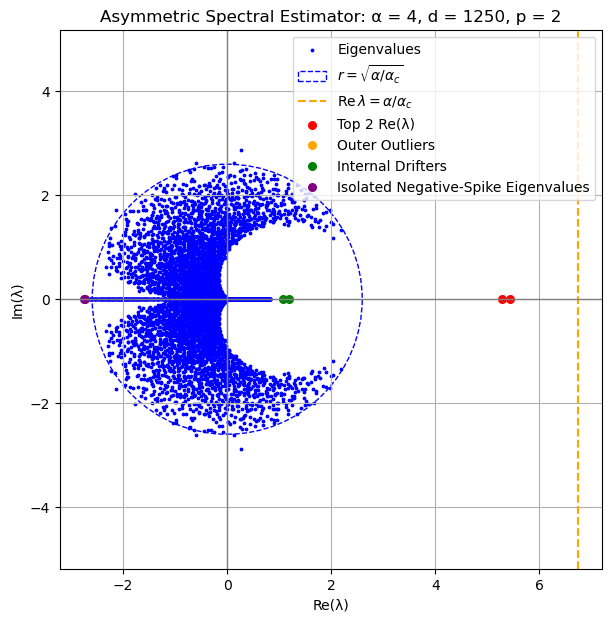


=== Rank-1 Overlap Summary ===
        Label  Overlap_q
0    Green2-2   0.512579
1    Green2-1   0.512579
2    Green1-2   0.502130
3    Green1-1   0.502129
4      Red1-2   0.351025
5      Red1-1   0.351025
6      Red2-1   0.310806
7      Red2-2   0.310806
8   Purple1-1   0.004448
9   Purple1-2   0.004448
10  Purple2-1   0.000255
11  Purple2-2   0.000255
Mean: 0.2802 | Max: 0.5126 | Min: 0.0003

===  Rank-2 Overlap Combinations ===
               ComboLabel  Rank2_Overlap_q
0     Green2-2 + Green1-1         1.014794
1     Green2-2 + Green1-2         1.014794
2     Green2-1 + Green1-1         1.014793
3     Green2-1 + Green1-2         1.014793
4       Green1-1 + Red1-2         0.853292
..                    ...              ...
61  Purple1-1 + Purple2-1         0.004747
62  Purple1-2 + Purple2-1         0.004747
63  Purple1-1 + Purple2-2         0.004747
64  Purple1-2 + Purple2-2         0.004747
65  Purple2-1 + Purple2-2         0.003498

[66 rows x 2 columns]


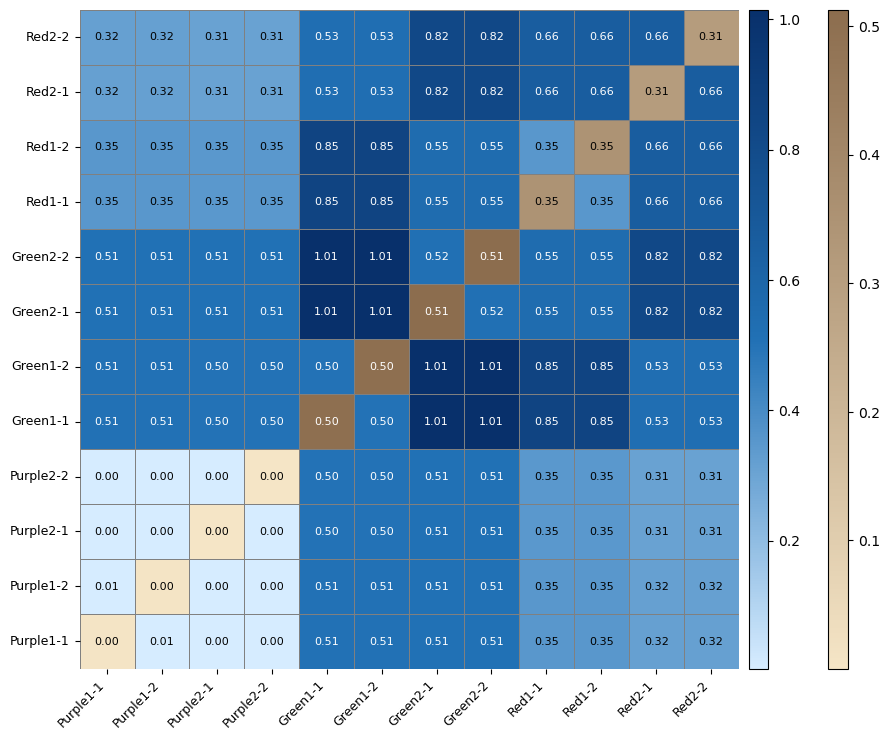

In [ ]:
# Dependencies
import os, random
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.linalg import qr
from scipy.special import kv as besselk
from matplotlib.colors import LinearSegmentedColormap, to_rgb
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable

# Utility functions
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def get_text_color(value, cmap, vmin, vmax):
    rgba = cmap((value - vmin) / (vmax - vmin))
    r, g, b = to_rgb(rgba[:3])
    luminance = 0.299 * r + 0.587 * g + 0.114 * b
    return 'black' if luminance > 0.5 else 'white'

def generalized_overlap_corrected(W_star, eigvals_np, eigvecs_np, target_vals, label_prefix, X):
    results = []
    d = W_star.shape[0]
    W_orth, _ = qr(W_star, mode='economic')
    X_cpu = X.cpu().numpy().T
    for i, val in enumerate(target_vals):
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx]
        V = v_hat.reshape(-1, 2)
        U = X_cpu @ V
        for j in range(2):
            u = U[:, j]
            u_hat = u / np.linalg.norm(u)
            q = np.linalg.norm(W_orth.T @ u_hat)**2
            results.append((f"{label_prefix}{i+1}-{j+1}", val, q))
    return results

def rank2_overlap_from_labels(W_star_np, eigvals_np, eigvecs_np, df_result, X):
    results = []
    W_orth, _ = qr(W_star_np, mode='economic')
    X_cpu = X.cpu().numpy().T
    v_map = {}
    for row in df_result.itertuples():
        label = row.Label
        val = row.Eigenvalue
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx].reshape(-1, 2)
        j = 0 if '1' in label[-3:] else 1
        v_map[label] = v_hat[:, j]
    for (id1, v1), (id2, v2) in combinations(v_map.items(), 2):
        U = X_cpu @ np.column_stack([v1, v2])
        U, _ = qr(U, mode='economic')
        q = np.linalg.norm(W_orth.T @ U, ord='fro')**2
        results.append((f"{id1} + {id2}", q))
    return pd.DataFrame(results, columns=["ComboLabel", "Rank2_Overlap_q"]) \
             .sort_values("Rank2_Overlap_q", ascending=False).reset_index(drop=True)

# Parameter settings
set_seed(42)
n, p = 5000, 2
alpha = 4
alpha_c = 0.59375
R = np.sqrt(alpha / alpha_c)        # spectral radius
thresh_ext = alpha / alpha_c        # theoretical outlier threshold
d = int(n / alpha)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data generation
X = torch.randn(n, d, device=device) / np.sqrt(d)
W_star = torch.randn(d, p, device=device)
Z = X @ W_star
z1, z2 = Z[:, 0], Z[:, 1]
y = z1 * z2

# Construct G(y)
y_cpu = y.detach().cpu().numpy()
abs_y = np.abs(y_cpu)
K1, K0 = besselk(1, abs_y), besselk(0, abs_y)
lambda_y = abs_y * (K1 / K0) - 1
lambda_y[np.isnan(lambda_y)] = 0

G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y
G_y_np[:, 0, 1] = y_cpu
G_y_np[:, 1, 0] = y_cpu
G_y = torch.tensor(G_y_np, device=device)

# Construct spectral matrix
XXT = X @ X.T
XXT.fill_diagonal_(0.0)
A = XXT[:, :, None, None]
G_broadcast = G_y[None, :, :, :]
L_blocks = A * G_broadcast
L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)

# Eigen-decomposition and classification
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
W_star_np = W_star.cpu().numpy()

real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real = eigvals_np[real_mask]

red_vals = sorted(eigvals_real, key=lambda z: z.real, reverse=True)[:2]
orange_vals = [z for z in eigvals_real if abs(z) > R and z.real > 0 and z not in red_vals]
green_vals = sorted([z for z in eigvals_real if abs(z) <= R and z.real > 0], key=lambda z: z.real, reverse=True)[:2]
purple_vals = [z for z in eigvals_real if z.real < 0 and abs(z) > R][:2]

# Labels for eigenvalues
red_labels = [(f"Red{i+1}", z) for i, z in enumerate(red_vals)]
orange_labels = [(f"Orange{i+1}", z) for i, z in enumerate(orange_vals)]
green_labels = [(f"Green{i+1}", z) for i, z in enumerate(green_vals)]
purple_labels = [(f"Purple{i+1}", z) for i, z in enumerate(purple_vals)]

# Eigenvalue spectrum visualization
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")
plt.scatter([z.real for _, z in red_labels], [z.imag for _, z in red_labels], color="red", s=30, label="Top 2 Re(λ)")
plt.scatter([z.real for _, z in orange_labels], [z.imag for _, z in orange_labels], color="orange", s=30, label="Outer Outliers")
plt.scatter([z.real for _, z in green_labels], [z.imag for _, z in green_labels], color="green", s=30, label="Internal Drifters")
plt.scatter([z.real for _, z in purple_labels], [z.imag for _, z in purple_labels], color="purple", s=30, label="Isolated Negative-Spike Eigenvalues")
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# Compute and display rank-1 overlaps
df_result = pd.DataFrame(
    generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, red_vals, "Red", X) +
    generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, orange_vals, "Orange", X) +
    generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, green_vals, "Green", X) +
    generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, purple_vals, "Purple", X),
    columns=["Label", "Eigenvalue", "Overlap_q"]
).sort_values("Overlap_q", ascending=False).reset_index(drop=True)

print("\n=== Rank-1 Overlap Summary ===")
print(df_result[["Label", "Overlap_q"]])
print(f"Mean: {df_result['Overlap_q'].mean():.4f} | Max: {df_result['Overlap_q'].max():.4f} | Min: {df_result['Overlap_q'].min():.4f}")

# Compute rank-2 overlaps
df_rank2 = rank2_overlap_from_labels(W_star_np, eigvals_np, eigvecs_np, df_result, X)
print("\n=== Rank-2 Overlap Combinations ===")
print(df_rank2)

# Heatmap visualization
labels_rank1 = set(df_result["Label"])
labels_rank2 = set()
for combo in df_rank2["ComboLabel"]:
    a, b = combo.split(" + ")
    labels_rank2.update([a, b])
all_labels = sorted(labels_rank1.union(labels_rank2))
color_order = ["Purple", "Green", "Orange", "Red"]
sorted_labels = []
for color in color_order:
    sorted_labels.extend(sorted([l for l in all_labels if color.lower() in l.lower()]))

heatmap_matrix = pd.DataFrame(np.nan, index=sorted_labels, columns=sorted_labels)
for _, row in df_rank2.iterrows():
    a, b = row['ComboLabel'].split(' + ')
    heatmap_matrix.loc[a, b] = row['Rank2_Overlap_q']
    heatmap_matrix.loc[b, a] = row['Rank2_Overlap_q']
for _, row in df_result.iterrows():
    heatmap_matrix.loc[row['Label'], row['Label']] = row['Overlap_q']

cmap_rank2 = LinearSegmentedColormap.from_list("blue_grad", ["#D6ECFF", "#2171B5", "#08306B"])
cmap_rank1 = LinearSegmentedColormap.from_list("brown_grad", ["#F5E5C6", "#8C6D4E"])
rank1_vals = heatmap_matrix.values[np.eye(len(sorted_labels), dtype=bool)]
rank2_vals = heatmap_matrix.values[~np.eye(len(sorted_labels), dtype=bool)]
rank1_min, rank1_max = np.nanmin(rank1_vals), np.nanmax(rank1_vals)
rank2_min, rank2_max = np.nanmin(rank2_vals), np.nanmax(rank2_vals)

fig, ax = plt.subplots(figsize=(9, 8))
mask_rank1 = ~np.eye(len(sorted_labels), dtype=bool)
mask_rank2 = np.eye(len(sorted_labels), dtype=bool)

sns.heatmap(heatmap_matrix, mask=mask_rank2, cmap=cmap_rank2, annot=False, square=True,
            cbar=False, linewidths=0.5, linecolor='gray', ax=ax)
sns.heatmap(heatmap_matrix, mask=mask_rank1, cmap=cmap_rank1, annot=False, square=True,
            cbar=False, linewidths=0.5, linecolor='gray', ax=ax)

for i in range(len(sorted_labels)):
    for j in range(len(sorted_labels)):
        value = heatmap_matrix.iloc[i, j]
        if pd.isna(value):
            continue
        is_rank1 = (i == j)
        cmap = cmap_rank1 if is_rank1 else cmap_rank2
        vmin = rank1_min if is_rank1 else rank2_min
        vmax = rank1_max if is_rank1 else rank2_max
        color = get_text_color(value, cmap, vmin, vmax)
        ax.text(j + 0.5, i + 0.5, f"{value:.2f}", ha='center', va='center', color=color, fontsize=8)

divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="3%", pad=0.1)
cax2 = divider.append_axes("right", size="3%", pad=0.6)
fig.colorbar(ScalarMappable(cmap=cmap_rank2, norm=plt.Normalize(rank2_min, rank2_max)), cax=cax1)
fig.colorbar(ScalarMappable(cmap=cmap_rank1, norm=plt.Normalize(rank1_min, rank1_max)), cax=cax2)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)
ax.invert_yaxis()
plt.tight_layout()
plt.show()


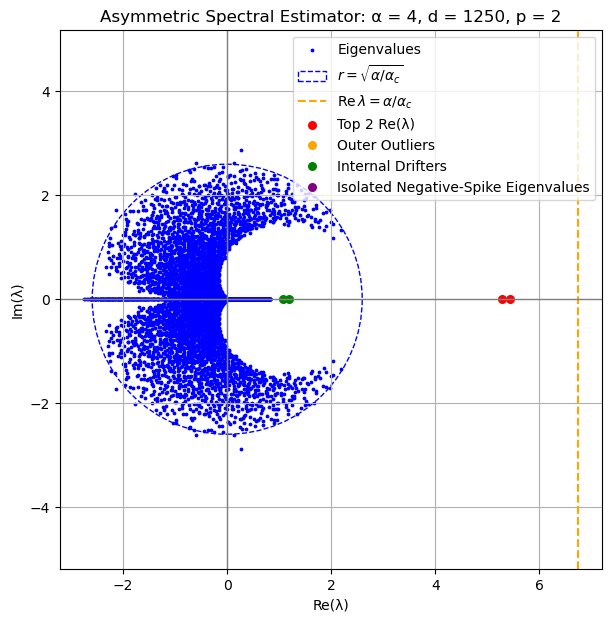


=== Alignment Score for Individual Eigenvalues ===
     Type                   λ  Alignment Score
0  Green1  1.189741+0.000000j         0.462084
1  Green2  1.070233+0.000000j         0.398308
2    Red1  5.441175+0.000000j         0.574586
3    Red2  5.286231+0.000000j         0.574138

=== Alignment Score for Pairs of Eigenvalues ===
            Pair                  λ1                  λ2  Alignment Score
5      Red1-Red2  5.441175+0.000000j  5.286231+0.000000j         0.574586
0  Green1-Green2  1.189741+0.000000j  1.070233+0.000000j         0.462084
1    Green1-Red1  1.189741+0.000000j  5.441175+0.000000j         0.462084
2    Green1-Red2  1.189741+0.000000j  5.286231+0.000000j         0.462084
3    Green2-Red1  1.070233+0.000000j  5.441175+0.000000j         0.398308
4    Green2-Red2  1.070233+0.000000j  5.286231+0.000000j         0.398308


/var/folders/kl/6hy0lk_14w14xqln8byr8l940000gn/T/ipykernel_4438/3281087079.py:226: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


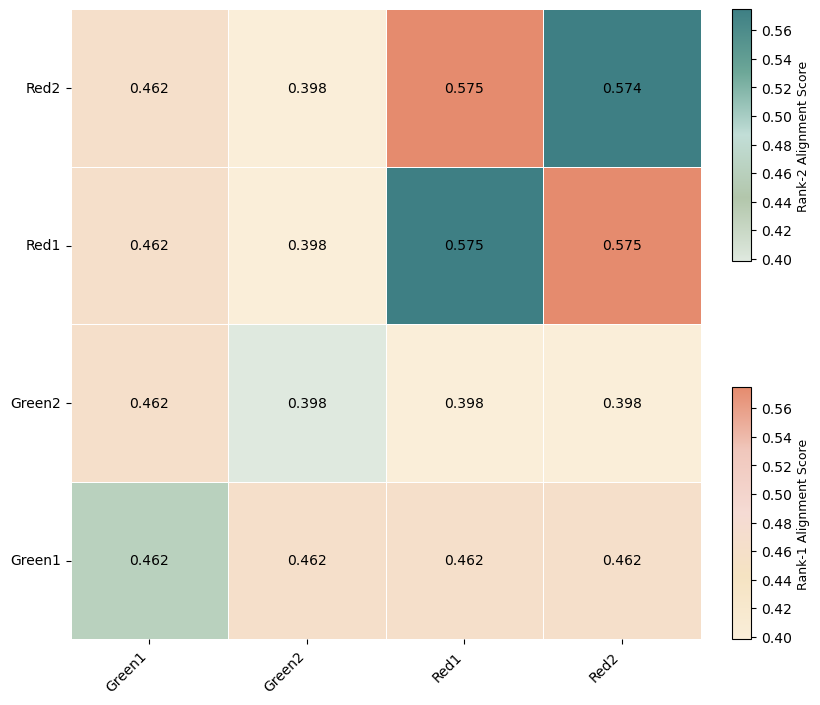

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy.linalg import norm
from scipy.linalg import qr
from itertools import combinations

# Alignment score between estimated and true subspaces
def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# Subspace extraction from a single eigenvalue
def extract_W_from_eigenvectors(eigvecs_np, eigval_target, X, W_star, p=2, label=""):
    idx = np.argmin(np.abs(eigvals_np - eigval_target))
    v_hat = eigvecs_np[:, idx]
    V = v_hat.reshape(-1, p)
    U = (X.cpu().numpy().T) @ V
    W_hat = U / np.linalg.norm(U, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_target, score)

# Subspace extraction from a pair of eigenvalues
def extract_W_from_eigpair(eigvecs_np, eigvals_np, eigval_pair, X, W_star, p=2, label=""):
    idx1 = np.argmin(np.abs(eigvals_np - eigval_pair[0]))
    idx2 = np.argmin(np.abs(eigvals_np - eigval_pair[1]))
    v1 = eigvecs_np[:, idx1]
    v2 = eigvecs_np[:, idx2]
    V1 = v1.reshape(-1, p)
    V2 = v2.reshape(-1, p)
    V = np.hstack([V1, V2])
    U = X.cpu().numpy().T @ V
    W_hat = U[:, :p]
    W_hat = W_hat / norm(W_hat, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_pair[0], eigval_pair[1], score)

# Eigenvalue decomposition
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()

# Eigenvalue classification: red, orange, green, purple

# Basic variables
R = np.sqrt(alpha / alpha_c)  # Radius threshold
eigvals_np = eigvals.cpu().numpy()
eigvals_real_only = [z for z in eigvals_np if np.isclose(z.imag, 0.0, atol=1e-6)]  # Real-valued eigenvalues only

# Red points: top two eigenvalues outside radius with largest positive real parts
outside_radius = [z for z in eigvals_real_only if abs(z) > R and z.real > 0]
red_vals = sorted(outside_radius, key=lambda z: z.real, reverse=True)[:2]

# Orange points: remaining positive eigenvalues outside radius
orange_vals = [z for z in outside_radius if z not in red_vals]

# Green points: top-n eigenvalues inside radius with largest real parts
green_candidates = [z for z in eigvals_real_only if abs(z) <= R]
green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:2]  # Adjustable [:n]

# Purple points: eigenvalues on negative real axis outside radius
purple_vals = [z for z in outside_vals if z.real < -R]

# Proper labeling (sorted by descending real part within each group)
green_vals_sorted = sorted(green_vals, key=lambda z: z.real, reverse=True)
green_labels = [(f"Green{i+1}", z) for i, z in enumerate(green_vals_sorted)]

orange_vals_sorted = sorted(orange_vals, key=lambda z: z.real, reverse=True)
orange_labels = [(f"Orange{i+1}", z) for i, z in enumerate(orange_vals_sorted)]

red_vals_sorted = sorted(red_vals, key=lambda z: z.real, reverse=True)
red_labels = [(f"Red{i+1}", z) for i, z in enumerate(red_vals_sorted)]

purple_vals_sorted = sorted(purple_vals, key=lambda z: z.real, reverse=True)
purple_labels = [(f"Purple{i+1}", z) for i, z in enumerate(purple_vals_sorted)]

# Merge labels for unified plotting
all_labels = green_labels + orange_labels + red_labels
label_order = [label for label, _ in all_labels]

# One-shot eigenvalue spectrum plot
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")
plt.scatter([z.real for _, z in red_labels], [z.imag for _, z in red_labels], color="red", s=30, label="Top 2 Re(λ)")
plt.scatter([z.real for _, z in orange_labels], [z.imag for _, z in orange_labels], color="orange", s=30, label="Outer Outliers")
plt.scatter([z.real for _, z in green_labels], [z.imag for _, z in green_labels], color="green", s=30, label="Internal Drifters")
plt.scatter([z.real for _, z in purple_labels], [z.imag for _, z in purple_labels], color="purple", s=30, label="Isolated Negative-Spike Eigenvalues")
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# Merge labels including purple points and redefine ordering
def build_desired_order(purple_labels, green_labels, orange_labels, red_labels):
    label_groups = [
        ("Purple", purple_labels),
        ("Green", green_labels),
        ("Orange", orange_labels),
        ("Red", red_labels),
    ]
    desired_order = []
    for color, labels in label_groups:
        for i, (label, _) in enumerate(labels):
            desired_order.append(label)
    return desired_order

label_dict = dict(green_labels + orange_labels + red_labels + purple_labels)
desired_order = build_desired_order(purple_labels, green_labels, orange_labels, red_labels)

all_labels = [(label, label_dict[label]) for label in desired_order if label in label_dict]
label_order = [label for label, _ in all_labels]

# Single-eigenvalue alignment scores
results_single = []
for label, z in all_labels:
    res = extract_W_from_eigenvectors(eigvecs_np, z, X, W_star, p=2, label=label)
    results_single.append(res)

df_single = pd.DataFrame(results_single, columns=["Type", "λ", "Alignment Score"])
print("\n=== Alignment Score for Individual Eigenvalues ===")
print(df_single)

# Pairwise alignment scores
results_pair = []
for (label1, z1), (label2, z2) in combinations(all_labels, 2):
    pair_label = f"{label1}-{label2}"
    results_pair.append(extract_W_from_eigpair(eigvecs_np, eigvals_np, (z1, z2), X, W_star, p=2, label=pair_label))

df_pair = pd.DataFrame(results_pair, columns=["Pair", "λ1", "λ2", "Alignment Score"])
print("\n=== Alignment Score for Pairs of Eigenvalues ===")
print(df_pair.sort_values(by="Alignment Score", ascending=False))

# Heatmap of alignment scores (including purple points)
heatmap_df = pd.DataFrame(np.nan, index=label_order, columns=label_order)

# Diagonal: single-eigenvalue alignment scores
for _, row in df_single.iterrows():
    label = row["Type"]
    score = row["Alignment Score"]
    heatmap_df.loc[label, label] = score

# Off-diagonal: pairwise alignment scores
for _, row in df_pair.iterrows():
    label1, label2 = row["Pair"].split("-")
    score = row["Alignment Score"]
    heatmap_df.loc[label1, label2] = score
    heatmap_df.loc[label2, label1] = score

# Plot masks
mask_diag = pd.DataFrame(True, index=label_order, columns=label_order)
np.fill_diagonal(mask_diag.values, False)
mask_offdiag = ~mask_diag

# Value range for color scaling
vmin = np.nanmin(heatmap_df.values)
vmax = np.nanmax(heatmap_df.values)

# Colormaps for diagonal and off-diagonal entries
diag_colors = ["#FAEED9", "#F5E3C2", "#F5DBD4", "#F0C7BC", "#E58B6E"]
offdiag_colors = ["#DFE9DF", "#B2C6AB", "#C2DED7", "#6DA798", "#3E7F84"]
diag_cmap = LinearSegmentedColormap.from_list("diag_cmap", diag_colors)
offdiag_cmap = LinearSegmentedColormap.from_list("offdiag_cmap", offdiag_colors)

# Plot heatmap
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(heatmap_df, mask=mask_diag, cmap=offdiag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)

# Colorbar for rank-2 alignment scores
cbar_ax1 = inset_axes(ax, width="3%", height="40%", loc='upper right',
                      bbox_to_anchor=(0.08, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
sm1 = plt.cm.ScalarMappable(cmap=offdiag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(sm1, cax=cbar_ax1).set_label("Rank-2 Alignment Score", fontsize=9)

# Overlay diagonal entries
sns.heatmap(heatmap_df, mask=mask_offdiag, cmap=diag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)

# Colorbar for rank-1 alignment scores
cbar_ax2 = inset_axes(ax, width="3%", height="40%", loc='lower right',
                      bbox_to_anchor=(0.08, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
sm2 = plt.cm.ScalarMappable(cmap=diag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(sm2, cax=cbar_ax2).set_label("Rank-1 Alignment Score", fontsize=9)

# Annotate scores on heatmap
for i in range(len(label_order)):
    for j in range(len(label_order)):
        val = heatmap_df.iloc[i, j]
        if not np.isnan(val):
            ax.text(j + 0.5, i + 0.5, f"{val:.3f}", ha='center', va='center', fontsize=10)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.invert_yaxis()
plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.90, top=0.95, bottom=0.05)
plt.show()


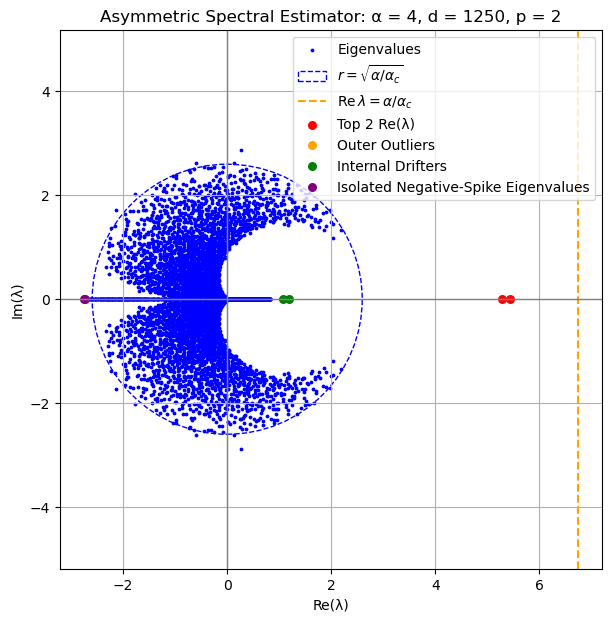


=== Alignment Score for Individual Eigenvalues ===
      Type                   λ  Alignment Score
0  Purple1 -2.726987+0.000000j         0.036080
1  Purple2 -2.745110+0.000000j         0.033397
2   Green1  1.189741+0.000000j         0.462084
3   Green2  1.070233+0.000000j         0.398308
4     Red1  5.441175+0.000000j         0.574586
5     Red2  5.286231+0.000000j         0.574138

=== Alignment Score for Pairs of Eigenvalues ===
               Pair                  λ1                  λ2  Alignment Score
14        Red1-Red2  5.441175+0.000000j  5.286231+0.000000j         0.574586
9     Green1-Green2  1.189741+0.000000j  1.070233+0.000000j         0.462084
10      Green1-Red1  1.189741+0.000000j  5.441175+0.000000j         0.462084
11      Green1-Red2  1.189741+0.000000j  5.286231+0.000000j         0.462084
12      Green2-Red1  1.070233+0.000000j  5.441175+0.000000j         0.398308
13      Green2-Red2  1.070233+0.000000j  5.286231+0.000000j         0.398308
0   Purple1-Purple2 -2.

/var/folders/kl/6hy0lk_14w14xqln8byr8l940000gn/T/ipykernel_4438/1282978277.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


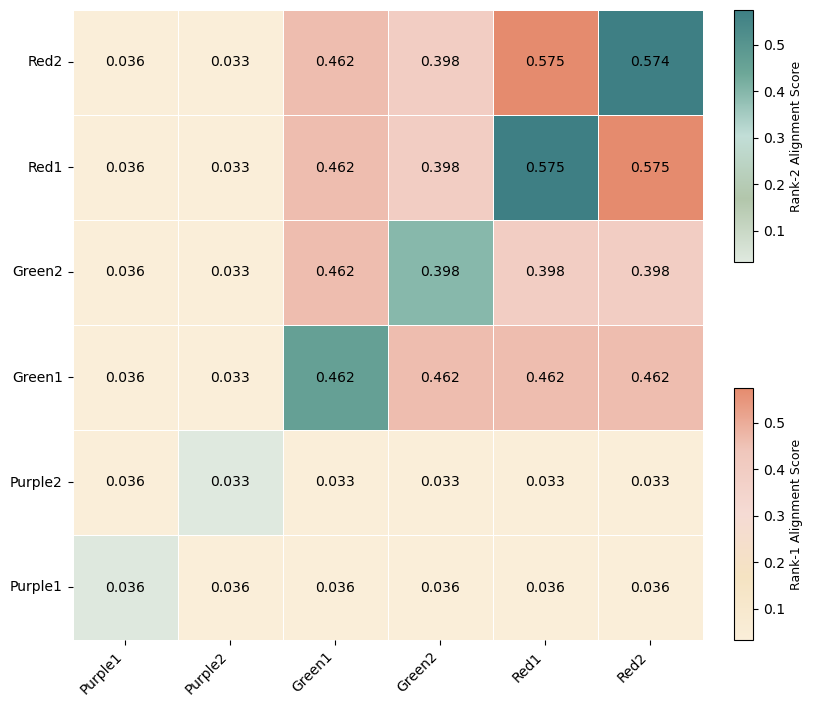

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy.linalg import norm
from scipy.linalg import qr
from itertools import combinations
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Threshold definitions
R = np.sqrt(alpha / alpha_c)        # Radius of the blue circle
thresh_ext = alpha / alpha_c        # Orange dashed line position

# Alignment score between estimated and true subspaces
def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# Subspace extraction from a single eigenvalue
def extract_W_from_eigenvectors(eigvecs_np, eigval_target, X, W_star, p=2, label=""):
    idx = np.argmin(np.abs(eigvals_np - eigval_target))
    v_hat = eigvecs_np[:, idx]
    V = v_hat.reshape(-1, p)
    U = (X.cpu().numpy().T) @ V
    W_hat = U / np.linalg.norm(U, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_target, score)

# Subspace extraction from a pair of eigenvalues
def extract_W_from_eigpair(eigvecs_np, eigvals_np, eigval_pair, X, W_star, p=2, label=""):
    idx1 = np.argmin(np.abs(eigvals_np - eigval_pair[0]))
    idx2 = np.argmin(np.abs(eigvals_np - eigval_pair[1]))
    v1 = eigvecs_np[:, idx1]
    v2 = eigvecs_np[:, idx2]
    V1 = v1.reshape(-1, p)
    V2 = v2.reshape(-1, p)
    V = np.hstack([V1, V2])
    U = X.cpu().numpy().T @ V
    W_hat = U[:, :p]
    W_hat = W_hat / norm(W_hat, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_pair[0], eigval_pair[1], score)

# Eigenvalue decomposition
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()

# Eigenvalue classification: red, orange, green, purple
R = np.sqrt(alpha / alpha_c)  # Radius threshold
eigvals_np = eigvals.cpu().numpy()
eigvals_real_only = [z for z in eigvals_np if np.isclose(z.imag, 0.0, atol=1e-6)]  # Real eigenvalues only

# Red points: top two eigenvalues outside radius with largest positive real parts
outside_radius = [z for z in eigvals_real_only if abs(z) > R and z.real > 0]
red_vals = sorted(outside_radius, key=lambda z: z.real, reverse=True)[:2]

# Orange points: remaining positive eigenvalues outside radius
orange_vals = [z for z in outside_radius if z not in red_vals]

# Green points: top-n eigenvalues inside radius with largest real parts
green_candidates = [z for z in eigvals_real_only if abs(z) <= R]
green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:2]  # Adjustable [:n]

# Purple points: negative eigenvalues outside radius
purple_vals = [z for z in eigvals_real_only if abs(z) > R and z.real < 0][:2]

# Label assignment (sorted by descending real part within each group)
green_vals_sorted = sorted(green_vals, key=lambda z: z.real, reverse=True)
green_labels = [(f"Green{i+1}", z) for i, z in enumerate(green_vals_sorted)]

orange_vals_sorted = sorted(orange_vals, key=lambda z: z.real, reverse=True)
orange_labels = [(f"Orange{i+1}", z) for i, z in enumerate(orange_vals_sorted)]

red_vals_sorted = sorted(red_vals, key=lambda z: z.real, reverse=True)
red_labels = [(f"Red{i+1}", z) for i, z in enumerate(red_vals_sorted)]

purple_vals_sorted = sorted(purple_vals, key=lambda z: z.real, reverse=True)
purple_labels = [(f"Purple{i+1}", z) for i, z in enumerate(purple_vals_sorted)]

# Merge labels for unified plotting
all_labels = green_labels + orange_labels + red_labels
label_order = [label for label, _ in all_labels]

# Eigenvalue spectrum plot
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")
plt.scatter([z.real for _, z in red_labels], [z.imag for _, z in red_labels], color="red", s=30, label="Top 2 Re(λ)")
plt.scatter([z.real for _, z in orange_labels], [z.imag for _, z in orange_labels], color="orange", s=30, label="Outer Outliers")
plt.scatter([z.real for _, z in green_labels], [z.imag for _, z in green_labels], color="green", s=30, label="Internal Drifters")
plt.scatter([z.real for _, z in purple_labels], [z.imag for _, z in purple_labels], color="purple", s=30, label="Isolated Negative-Spike Eigenvalues")
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# Merge labels including purple points and redefine order
def build_desired_order(purple_labels, green_labels, orange_labels, red_labels):
    label_groups = [
        ("Purple", purple_labels),
        ("Green", green_labels),
        ("Orange", orange_labels),
        ("Red", red_labels),
    ]
    desired_order = []
    for color, labels in label_groups:
        for i, (label, _) in enumerate(labels):
            desired_order.append(label)
    return desired_order

label_dict = dict(green_labels + orange_labels + red_labels + purple_labels)
desired_order = build_desired_order(purple_labels, green_labels, orange_labels, red_labels)
all_labels = [(label, label_dict[label]) for label in desired_order if label in label_dict]
label_order = [label for label, _ in all_labels]

# Single-eigenvalue alignment scores
results_single = []
for label, z in all_labels:
    res = extract_W_from_eigenvectors(eigvecs_np, z, X, W_star, p=2, label=label)
    results_single.append(res)

df_single = pd.DataFrame(results_single, columns=["Type", "λ", "Alignment Score"])
print("\n=== Alignment Score for Individual Eigenvalues ===")
print(df_single)

# Pairwise alignment scores
results_pair = []
for (label1, z1), (label2, z2) in combinations(all_labels, 2):
    pair_label = f"{label1}-{label2}"
    results_pair.append(extract_W_from_eigpair(eigvecs_np, eigvals_np, (z1, z2), X, W_star, p=2, label=pair_label))

df_pair = pd.DataFrame(results_pair, columns=["Pair", "λ1", "λ2", "Alignment Score"])
print("\n=== Alignment Score for Pairs of Eigenvalues ===")
print(df_pair.sort_values(by="Alignment Score", ascending=False))

# Heatmap of alignment scores (includes purple points)
heatmap_df = pd.DataFrame(np.nan, index=label_order, columns=label_order)

# Diagonal: single-eigenvalue scores
for _, row in df_single.iterrows():
    label = row["Type"]
    score = row["Alignment Score"]
    heatmap_df.loc[label, label] = score

# Off-diagonal: pairwise scores
for _, row in df_pair.iterrows():
    label1, label2 = row["Pair"].split("-")
    score = row["Alignment Score"]
    heatmap_df.loc[label1, label2] = score
    heatmap_df.loc[label2, label1] = score

# Create masks for diagonal and off-diagonal entries
mask_diag = pd.DataFrame(True, index=label_order, columns=label_order)
np.fill_diagonal(mask_diag.values, False)
mask_offdiag = ~mask_diag

# Value range for colormap scaling
vmin = np.nanmin(heatmap_df.values)
vmax = np.nanmax(heatmap_df.values)

# Colormaps for diagonal and off-diagonal entries
diag_colors = ["#FAEED9", "#F5E3C2", "#F5DBD4", "#F0C7BC", "#E58B6E"]
offdiag_colors = ["#DFE9DF", "#B2C6AB", "#C2DED7", "#6DA798", "#3E7F84"]
diag_cmap = LinearSegmentedColormap.from_list("diag_cmap", diag_colors)
offdiag_cmap = LinearSegmentedColormap.from_list("offdiag_cmap", offdiag_colors)

# Draw heatmap
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(heatmap_df, mask=mask_diag, cmap=offdiag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)

# Colorbar for rank-2 alignment scores
cbar_ax1 = inset_axes(ax, width="3%", height="40%", loc='upper right',
                      bbox_to_anchor=(0.08, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
sm1 = plt.cm.ScalarMappable(cmap=offdiag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(sm1, cax=cbar_ax1).set_label("Rank-2 Alignment Score", fontsize=9)

# Overlay diagonal entries
sns.heatmap(heatmap_df, mask=mask_offdiag, cmap=diag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)

# Colorbar for rank-1 alignment scores
cbar_ax2 = inset_axes(ax, width="3%", height="40%", loc='lower right',
                      bbox_to_anchor=(0.08, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
sm2 = plt.cm.ScalarMappable(cmap=diag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(sm2, cax=cbar_ax2).set_label("Rank-1 Alignment Score", fontsize=9)

# Annotate alignment scores on heatmap
for i in range(len(label_order)):
    for j in range(len(label_order)):
        val = heatmap_df.iloc[i, j]
        if not np.isnan(val):
            ax.text(j + 0.5, i + 0.5, f"{val:.3f}", ha='center', va='center', fontsize=10)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.invert_yaxis()
plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.90, top=0.95, bottom=0.05)
plt.show()
